In [201]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install lightning==2.2.5 opencv-python numpy pandas matplotlib

# 1) Imports y configuración

In [202]:
from pathlib import Path
import re, math, json, random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, RichProgressBar, Callback
from lightning import seed_everything  

seed_everything(42, workers=True)

DATA_DIR = "data"          
T_IN     = 5               
T_OUT    = 4               
BATCH    = 32
LR       = 1e-3
EPOCHS   = 80
HIDDEN   = 64              
NUM_LAY  = 1               
LAMBDA_V = 0.1             # peso del término de velocidad
NUM_WORKERS = 0 #4

Seed set to 42


# 2) Utilidades: centroides, carga por lanzamiento, normalización

In [203]:
def get_ball_center(gray_img: np.ndarray):
    """Retorna (cx, cy, area) del blob blanco; None si no hay blob."""
    _, binim = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
    M = cv2.moments(binim)
    if M["m00"] == 0:
        return None
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    area = M["m00"] / 255.0
    return float(cx), float(cy), float(area)

def sorted_frames(folder: Path):
    """Lista de paths ordenados alfabéticamente (asume nombres con orden temporal)."""
    imgs = sorted([p for p in folder.glob("*.jpg")])
    return imgs

def load_launch_sequences(base_dir: str, min_len: int = 1):
    base = Path(base_dir)
    launch_dirs = [d for d in base.iterdir() if d.is_dir()]
    sequences = {}
    width = height = None

    empty_ids = []   
    short_ids = []   # < min_len

    for d in sorted(launch_dirs):
        frames = sorted_frames(d)
        seq = []
        for fp in frames:
            img = cv2.imread(str(fp), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            h, w = img.shape
            if height is None: height, width = h, w
            c = get_ball_center(img)
            if c is not None:
                seq.append(c)  

        arr = np.array(seq, dtype=np.float32).reshape(-1, 3) 
        if arr.shape[0] == 0:
            empty_ids.append(d.name)
            continue  

        if arr.shape[0] < min_len:
            short_ids.append((d.name, arr.shape[0]))

        sequences[d.name] = arr

    print(f"Secuencias cargadas: {len(sequences)}  | Vacías: {len(empty_ids)}  | <{min_len}: {len(short_ids)}")
    if empty_ids:
        print("IDs vacíos (sin detecciones):", empty_ids[:10], "..." if len(empty_ids) > 10 else "")
    if short_ids:
        print("IDs cortos:", short_ids[:10], "..." if len(short_ids) > 10 else "")
    return sequences, width, height

DATA_DIR = "fotos_binarizadas_limpias"

sequences_raw, W, H = load_launch_sequences(DATA_DIR)
print(f"Lanzamientos válidos: {len(sequences_raw)}  | Tamaño imagen: {W}x{H}")

Secuencias cargadas: 257  | Vacías: 7  | <1: 0
IDs vacíos (sin detecciones): ['1c237575-13e9-493f-98d0-890cda03fd38', '3df38b0a-3fc4-4c59-9949-a8fd92100fe9', '77edd9b7-f5c4-4bbf-b324-8cdc07deb694', 'a0df7010-406b-4b90-b86f-16fbc20fd213', 'a1af1c19-0e2c-4e27-969c-71e39c43db98', 'ae167887-866f-432f-9ba4-00f3eecd4d1c', 'ca3f8749-095f-4975-9ec6-d8a25003bd0e'] 
Lanzamientos válidos: 257  | Tamaño imagen: 640x480


# Dibujando una Muestra de las Trayectorias :

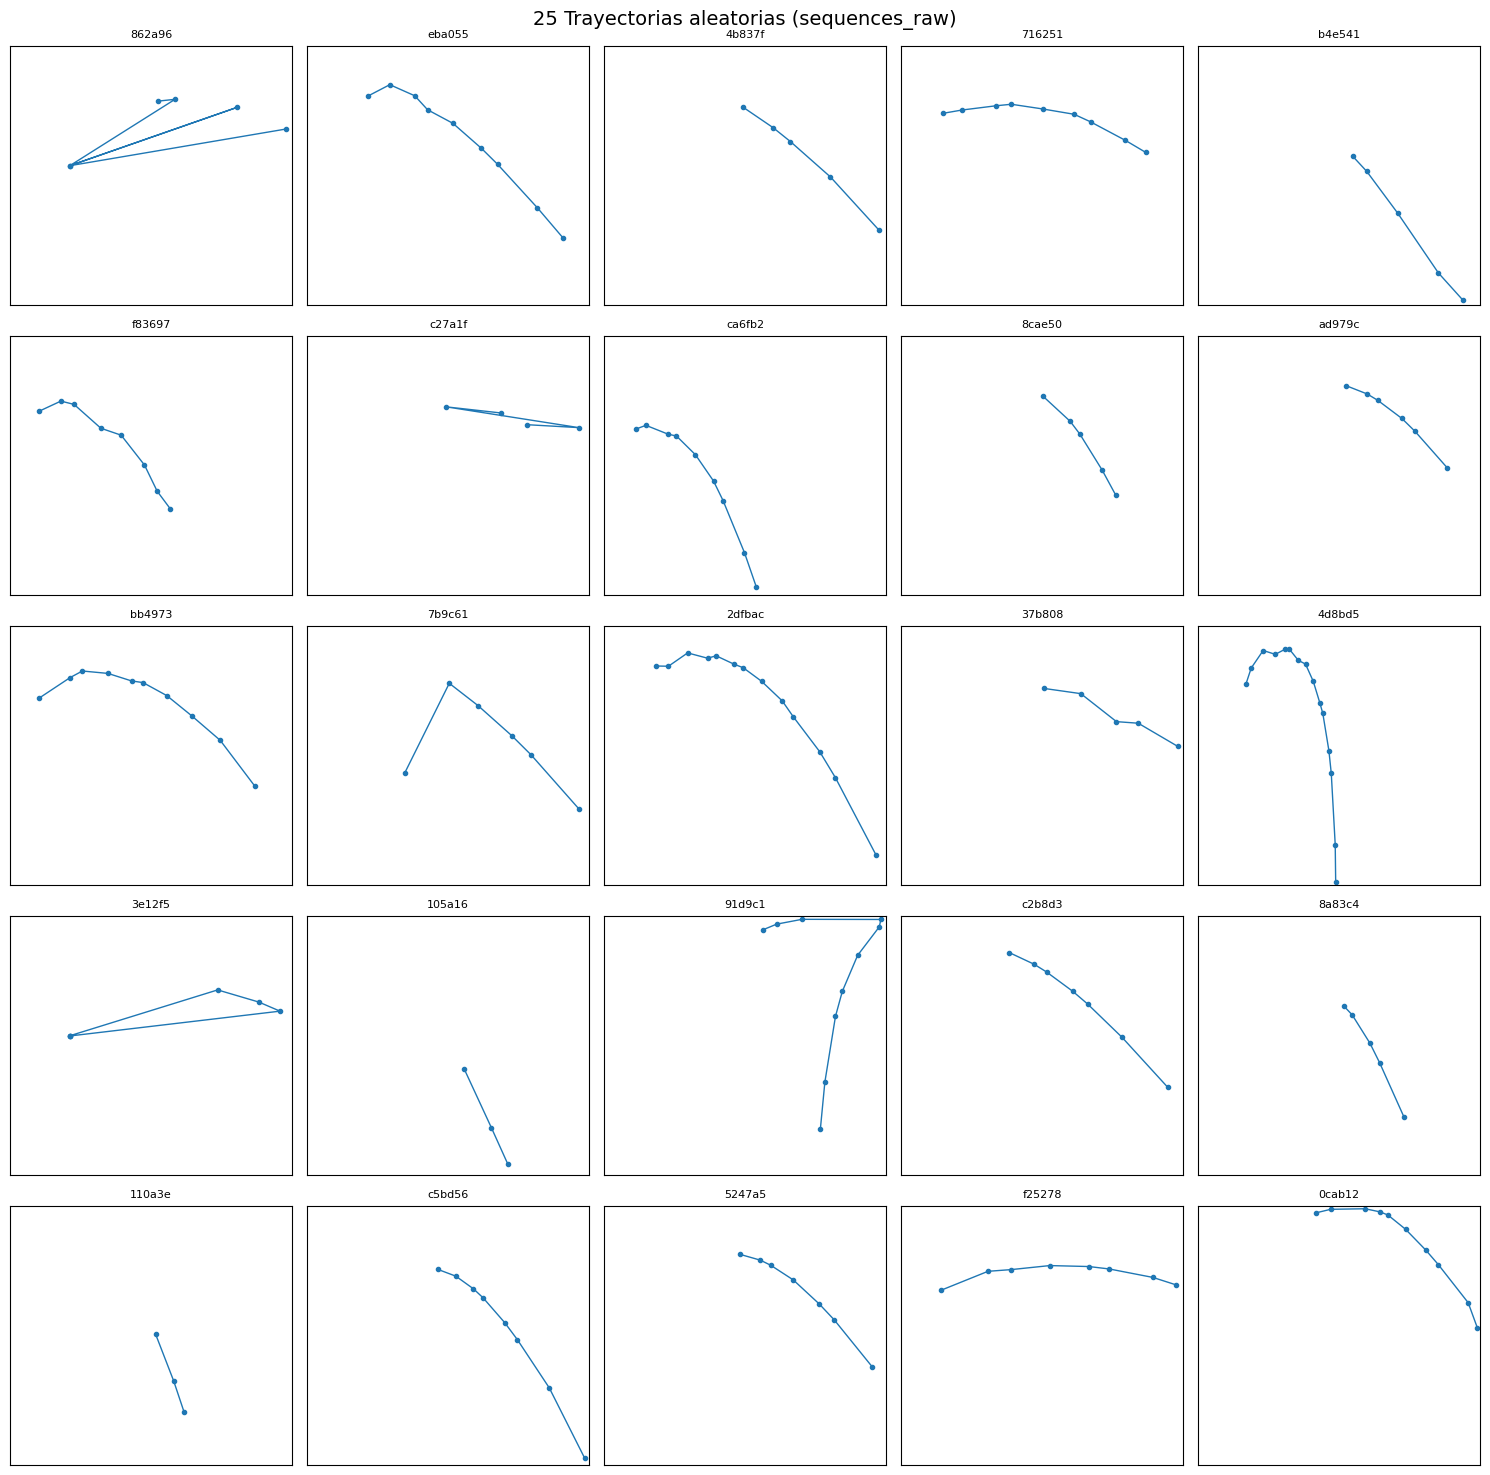

In [218]:
import matplotlib.pyplot as plt
import random

def plot_random_trajectories(sequences_raw, n_samples=25, W=640, H=480):
    ids = random.sample(list(sequences_raw.keys()), min(n_samples, len(sequences_raw)))

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()

    for i, (ax, sid) in enumerate(zip(axes, ids)):
        seq = sequences_raw[sid]  
        x, y = seq[:, 0], seq[:, 1]

        ax.plot(x, y, marker="o", markersize=3, linewidth=1, label="trayectoria")
        ax.set_title(sid[:6], fontsize=8)  
        ax.invert_yaxis()   
        ax.set_xlim(0, W)
        ax.set_ylim(H, 0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("25 Trayectorias aleatorias (sequences_raw)", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_random_trajectories(sequences_raw, n_samples=25, W=W, H=H)

In [205]:
import numpy as np
import math

def sample_hyperbola_seq_safe(
    T=20, W=640, H=480,
    x_margin=0.10, y_margin=0.10,
    xc_range=(0.35, 0.65), yc_range=(0.35, 0.65),
    min_dx=0.12, max_dx=0.30,           # distancia mínima a la asíntota
    k_abs_max=0.25,                     # cota superior para |k| (en espacio normalizado)
    noise_xy=0.0025,
    drift=0.0,
    max_retries=500
):
    """
    Genera una secuencia hiperbólica y=yc + k/(x-xc) en normalizado, la valida y la
    devuelve en PIXELES como [T,3] (x_px, y_px, area_px). Retorna None si no pudo.
    """
    for _ in range(max_retries):
        # Centro
        xc = np.random.uniform(*xc_range)
        yc = np.random.uniform(*yc_range)

        # Elegir lado (izq o der) y rango de x, lejos de xc (evitar singularidad)
        dx = np.random.uniform(min_dx, max_dx)
        side_right = np.random.rand() < 0.5
        if side_right:
            x_lo = max(xc + dx, x_margin)
            x_hi = 1.0 - x_margin
        else:
            x_lo = x_margin
            x_hi = min(xc - dx, 1.0 - x_margin)

        if not (x_hi - x_lo > 0.05):
            continue  # rango muy chico, reintenta

        # Construye xs en ese rango, aleatoriamente forward/backward
        xs = np.linspace(x_lo, x_hi, T)
        if np.random.rand() < 0.5:
            xs = xs[::-1]

        # Elige una altura destino segura para el primer punto y calcula k:
        # y1 = yc + k/(x1-xc)  ->  k = (y1 - yc) * (x1 - xc)
        y_target = np.random.uniform(y_margin, 1.0 - y_margin)
        denom1 = xs[0] - xc
        if abs(denom1) < min_dx:
            continue
        k = (y_target - yc) * denom1

        # Acota |k| para no generar pendientes enormes
        if abs(k) > k_abs_max:
            k = np.sign(k) * np.random.uniform(0.05, k_abs_max)

        # Genera la curva completa
        denom = xs - xc
        if np.any(np.isclose(denom, 0.0, atol=1e-6)):
            continue

        ys = yc + (k / denom)

        # Deriva opcional (muy pequeña)
        if drift != 0.0:
            tvec = np.linspace(0, 1, T)
            xs = xs + drift * tvec
            ys = ys + drift * tvec

        # Agrega ruido suave
        xs_noisy = xs + np.random.normal(0, noise_xy, size=T)
        ys_noisy = ys + np.random.normal(0, noise_xy, size=T)

        # Validación de límites
        ok = (
            xs_noisy.min() >= 0.0 and xs_noisy.max() <= 1.0 and
            ys_noisy.min() >= y_margin and ys_noisy.max() <= 1.0 - y_margin and
            np.isfinite(xs_noisy).all() and np.isfinite(ys_noisy).all()
        )
        if not ok:
            continue

        # A pixeles
        x_px = (xs_noisy * W).astype(np.float32)
        y_px = (ys_noisy * H).astype(np.float32)
        area_px = (np.full(T, 200.0) * (1.0 + 0.05*np.random.randn(T))).astype(np.float32)
        return np.stack([x_px, y_px, area_px], axis=1).astype(np.float32)

    return None

def make_hyperbolic_synthetics_safe(N=100, T=20, W=640, H=480, **kwargs):
    synthetics = {}
    created = 0
    attempts = 0
    while created < N and attempts < N*50:
        attempts += 1
        seq = sample_hyperbola_seq_safe(T=T, W=W, H=H, **kwargs)
        if seq is not None:
            sid = f"synthetic_hyper_{created:04d}"
            synthetics[sid] = seq
            created += 1
    return synthetics

In [206]:
N_SYN = 150000
T_SYN = max(T_IN + T_OUT, 20)

synthetic_dict = make_hyperbolic_synthetics_safe(
    N=N_SYN, T=T_SYN, W=W, H=H,
    x_margin=0.12, y_margin=0.12,        # márgenes generosos
    min_dx=0.15, max_dx=0.30,            # lejos de la asíntota
    k_abs_max=0.18,                      # controla la curvatura
    noise_xy=0.0018,                     # ruido moderado
    drift=0.0
)
print("Sintéticos creados:", len(synthetic_dict))

Sintéticos creados: 150000


# 3) Preprocesado: features, velocidades, normalización

In [207]:
def build_features(seq_xyA: np.ndarray, W: int, H: int):
    """
    Entrada: seq[T, 3] con columnas [x, y, area] en pixeles.
    Salida:  seq[T, F] con F = [x', y', vx', vy', area'] normalizados.
    """
    x = seq_xyA[:, 0] / W
    #y = seq_xyA[:, 1] / H
    #Inverting Y axis

    y = 1.0 - (seq_xyA[:, 1] / H)   # y=1 arriba, y=0 abajo
    #vy[1:] = y[1:] - y[:-1]

    A = seq_xyA[:, 2] / (W * H)

    # Derivadas discretas (velocidad). Pon 0 en el primer paso.
    vx = np.zeros_like(x)
    vy = np.zeros_like(y)
    vx[1:] = x[1:] - x[:-1]
    vy[1:] = y[1:] - y[:-1]

    feats = np.stack([x, y, vx, vy, A], axis=1).astype(np.float32)
    return feats

sequences = {k: build_features(v, W, H) for k, v in sequences_raw.items()}

# 4) Split por lanzamiento (no mezclar)

In [208]:
all_ids = sorted(list(sequences.keys()))
random.shuffle(all_ids)

n = len(all_ids)
n_train = int(0.7 * n)
n_val   = int(0.20 * n)
train_ids = all_ids[:n_train]
val_ids   = all_ids[n_train:n_train+n_val]
test_ids  = all_ids[n_train+n_val:]

print("Split por lanzamiento:")
print("Train:", len(train_ids), "Val:", len(val_ids), "Test:", len(test_ids))

Split por lanzamiento:
Train: 179 Val: 51 Test: 27


# 5) Dataset con ventanas (T_in → T_out)

In [209]:
class BallTrajDataset(Dataset):
    """
    X: [T_in, F] con F=[x,y,vx,vy,area] normalizados
    Y: [T_out, 2] solo posiciones futuras normalizadas (x,y)
    """
    def __init__(self, seqs_dict, ids, T_in=6, T_out=6):
        self.X, self.Y = [], []
        for lid in ids:
            seq = seqs_dict[lid]
            T = len(seq)
            for t in range(T - T_in - T_out + 1):
                xwin = seq[t:t+T_in, :]
                ywin = seq[t+T_in:t+T_in+T_out, :2]
                self.X.append(xwin)
                self.Y.append(ywin)
        self.X = torch.tensor(np.stack(self.X), dtype=torch.float32)
        self.Y = torch.tensor(np.stack(self.Y), dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

train_ds = BallTrajDataset(sequences, train_ids, T_IN, T_OUT)
val_ds   = BallTrajDataset(sequences, val_ids,   T_IN, T_OUT)
test_ds  = BallTrajDataset(sequences, test_ids,  T_IN, T_OUT)

print(len(train_ds), len(val_ds), len(test_ds))

78 28 16


# 6) DataModule (Lightning)

In [210]:
class BallDataModule(L.LightningDataModule):
    def __init__(self, train_ds, val_ds, test_ds, batch_size=32, num_workers=4):
        super().__init__()
        self.train_ds = train_ds
        self.val_ds   = val_ds
        self.test_ds  = test_ds
        self.batch_size = batch_size
        self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

dm = BallDataModule(train_ds, val_ds, test_ds, BATCH, NUM_WORKERS)

# 7) Modelo GRU (LightningModule) + pérdida con suavidad de velocidad

In [211]:
class GRUTraj(L.LightningModule):
    def __init__(self, in_f=5, hidden=64, num_layers=1, T_out=6, lr=1e-3, lambda_v=0.1):
        super().__init__()
        self.save_hyperparameters()

        #self.gru = nn.GRU(input_size=in_f, hidden_size=hidden, num_layers=num_layers, batch_first=True)
        self.gru = self.gru = nn.GRU(
    input_size=in_f, 
    hidden_size=hidden, 
    num_layers=num_layers,
    dropout=0.2 if NUM_LAY > 1 else 0.0,  # 👈 dropout solo si hay más de 1 capa
    batch_first=True
)
        self.head = nn.Linear(hidden, 2*T_out)

    def forward(self, x):  # x: [B, T_in, F]
        out, _ = self.gru(x)           # [B, T_in, hidden]
        z = out[:, -1, :]              # último paso
        yhat = self.head(z).view(-1, self.hparams.T_out, 2)  # [B, T_out, 2]
        return yhat

    def _loss_old(self, yhat, y):
        loss_pos = F.mse_loss(yhat, y)
        dv_hat = yhat[:, 1:] - yhat[:, :-1]
        dv     = y[:, 1:]    - y[:, :-1]
        loss_vel = F.mse_loss(dv_hat, dv)
        return loss_pos + self.hparams.lambda_v * loss_vel

    def _loss(self, yhat, y):
        # yhat, y: [B, T_out, 2]
        # Error por frame
        per_step_err = F.mse_loss(yhat, y, reduction="none").mean(dim=-1)  # [B, T_out]

        # Ponderar más el último paso
        weights = torch.linspace(0.5, 2.0, steps=self.hparams.T_out, device=y.device)  # ejemplo: 0.5 → 2.0
        loss_pos = (per_step_err * weights).mean()

        # Suavidad en velocidad (igual que antes)
        dv_hat = yhat[:, 1:] - yhat[:, :-1]
        dv     = y[:, 1:]    - y[:, :-1]
        loss_vel = F.mse_loss(dv_hat, dv)

        return loss_pos + self.hparams.lambda_v * loss_vel

    @torch.no_grad()
    def _ade_fde(self, yhat, y):
        # yhat,y: [B, T_out, 2] en espacio normalizado
        err = torch.linalg.vector_norm(yhat - y, dim=-1)  # [B, T_out]
        ade = err.mean()
        fde = err[:, -1].mean()
        return ade, fde

    def training_step(self, batch, _):
        x, y = batch
        yhat = self(x)
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        self.log_dict({"train/loss": loss, "train/ADE": ade, "train/FDE": fde}, prog_bar=True)
        return loss

    def validation_step(self, batch, _):
        x, y = batch
        yhat = self(x)
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        self.log_dict({"val/loss": loss, "val/ADE": ade, "val/FDE": fde}, prog_bar=True)

    def test_step(self, batch, _):
        x, y = batch
        yhat = self(x)
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        self.log_dict({"test/loss": loss, "test/ADE": ade, "test/FDE": fde})

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=5, factor=0.5)#, verbose=True)
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "monitor": "val/loss"}}

# 8) Entrenamiento (EarlyStopping, checkpoints, logging)

In [212]:
# 1) Unir a tus sequences_raw (que están en PIXELES)
sequences_raw_aug = sequences_raw.copy()
sequences_raw_aug.update(synthetic_dict)

# 2) Re-hacer features normalizados para TODOS (usar tu función existente)
sequences_aug = {k: build_features(v, W, H) for k, v in sequences_raw_aug.items()}

# 3) Mantén splits por lanzamiento: agrega SOLO los sintéticos al train
all_ids_real = sorted(list(sequences.keys()))  # reales normalizados que ya habías hecho
all_ids_syn  = sorted(list(synthetic_dict.keys()))

# Mantén tus splits reales (train_ids, val_ids, test_ids) y añade sintéticos al train:
train_ids_aug = train_ids + all_ids_syn

# 4) Construir datasets con el diccionario ampliado
train_ds = BallTrajDataset(sequences_aug, train_ids_aug, T_IN, T_OUT)
val_ds   = BallTrajDataset(sequences_aug, val_ids,       T_IN, T_OUT)
test_ds  = BallTrajDataset(sequences_aug, test_ids,      T_IN, T_OUT)

print("Ventanas con sintéticos →",
      "train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

Ventanas con sintéticos → train: 1800078 val: 28 test: 16


In [213]:
model = GRUTraj(in_f=5, hidden=HIDDEN, num_layers=NUM_LAY, T_out=T_OUT, lr=LR, lambda_v=LAMBDA_V)

logger = CSVLogger("lightning_logs", name="ball_gru")
ckpt = ModelCheckpoint(
    monitor="val/loss", mode="min", save_top_k=1,
    filename="epoch{epoch:02d}-valloss{val/loss:.4f}"
)
early = EarlyStopping(monitor="val/loss", mode="min", patience=10)
lrm   = LearningRateMonitor(logging_interval="epoch")
bar   = RichProgressBar()

trainer = L.Trainer(
    max_epochs=EPOCHS,
    accelerator="auto",
    logger=logger,
    callbacks=[ckpt, early, lrm, bar],
    deterministic=True,
)

trainer.fit(model, datamodule=dm)
print("Mejor checkpoint:", ckpt.best_model_path)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type   ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ 0 │ gru  │ GRU    │ 13.6 K │
│ 1 │ head │ Linear │    520 │
└───┴──────┴────────┴────────┘

Trainable params: 14.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.2 K                                                                                               
Total estimated model params size (MB): 0

/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_con
nector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.

/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: 
UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be 
used.
  warnings.warn(warn_msg)

/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_con
nector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the
value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.

/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The 
number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

Mejor checkpoint: lightning_logs/ball_gru/version_25/checkpoints/epochepoch=22-vallossval/loss=0.0614.ckpt


# 9) Evaluación en test

In [214]:
best = GRUTraj.load_from_checkpoint(ckpt.best_model_path)
trainer.test(best, datamodule=dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/ADE          │    0.1614101529121399     │
│         test/FDE          │    0.21421600878238678    │
│         test/loss         │   0.024605443701148033    │
└───────────────────────────┴───────────────────────────┘

/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


[{'test/loss': 0.024605443701148033,
  'test/ADE': 0.1614101529121399,
  'test/FDE': 0.21421600878238678}]

# 10) Gráfica de aprendizaje (loss y ADE/FDE)

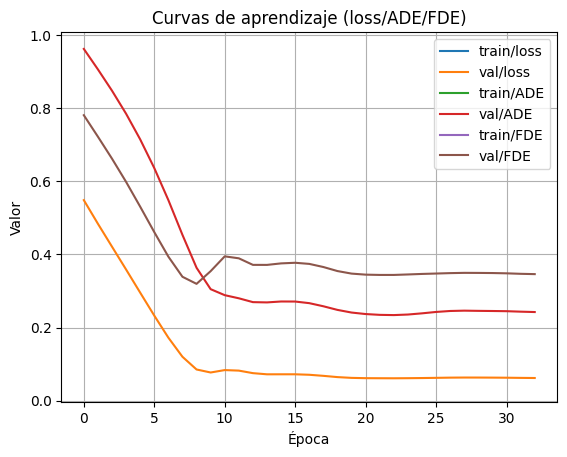

In [215]:
run_dir = Path(logger.log_dir)  
metrics_csv = run_dir / "metrics.csv"
df = pd.read_csv(metrics_csv)

# Tomar último valor válido por época
def last_valid_per_epoch(df, col):
    tmp = df[["epoch", col]].dropna()
    return tmp.groupby("epoch").tail(1)

cols = ["train/loss", "val/loss", "train/ADE", "val/ADE", "train/FDE", "val/FDE"]
curves = {c: last_valid_per_epoch(df, c) for c in cols if c in df.columns}

plt.figure()
for c, dd in curves.items():
    plt.plot(dd["epoch"], dd[c], label=c)
plt.xlabel("Época"); plt.ylabel("Valor"); plt.title("Curvas de aprendizaje (loss/ADE/FDE)")
plt.legend()
plt.grid(True)
plt.show()

# 11) Visualización de predicciones 

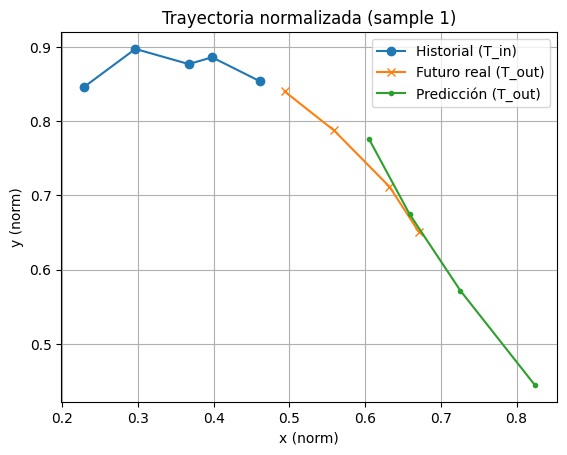

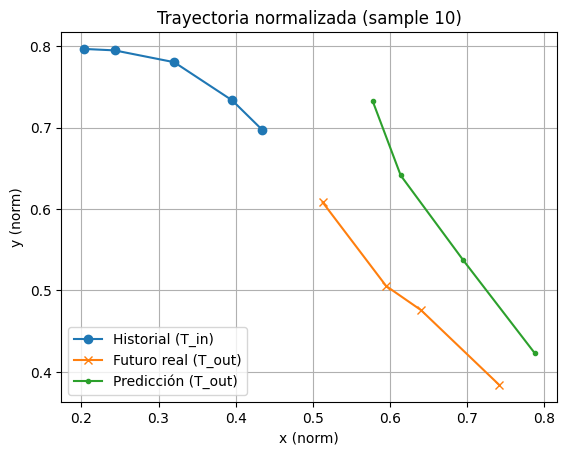

In [216]:
@torch.no_grad()
def visualize_random_case(model, dataset, k=3):
    model.eval()
    idxs = random.sample(range(len(dataset)), k=min(k, len(dataset)))
    for i in idxs:
        X, Y = dataset[i]
        Yhat = model(X.unsqueeze(0)).squeeze(0).cpu()  # [T_out, 2]
        X = X.cpu(); Y = Y.cpu()

        xs_hist, ys_hist = X[:,0].numpy(), X[:,1].numpy()
        xs_true, ys_true = Y[:,0].numpy(), Y[:,1].numpy()
        xs_hat,  ys_hat  = Yhat[:,0].numpy(), Yhat[:,1].numpy()

        plt.figure()
        plt.plot(xs_hist, ys_hist, marker="o", label="Historial (T_in)")
        plt.plot(xs_true, ys_true, marker="x", label="Futuro real (T_out)")
        plt.plot(xs_hat,  ys_hat,  marker=".", label="Predicción (T_out)")
        plt.xlabel("x (norm)"); plt.ylabel("y (norm)")
        plt.title(f"Trayectoria normalizada (sample {i})")
        plt.legend(); plt.grid(True); plt.show()

best_cpu = best.to("cpu")
visualize_random_case(best_cpu, test_ds, k=2)

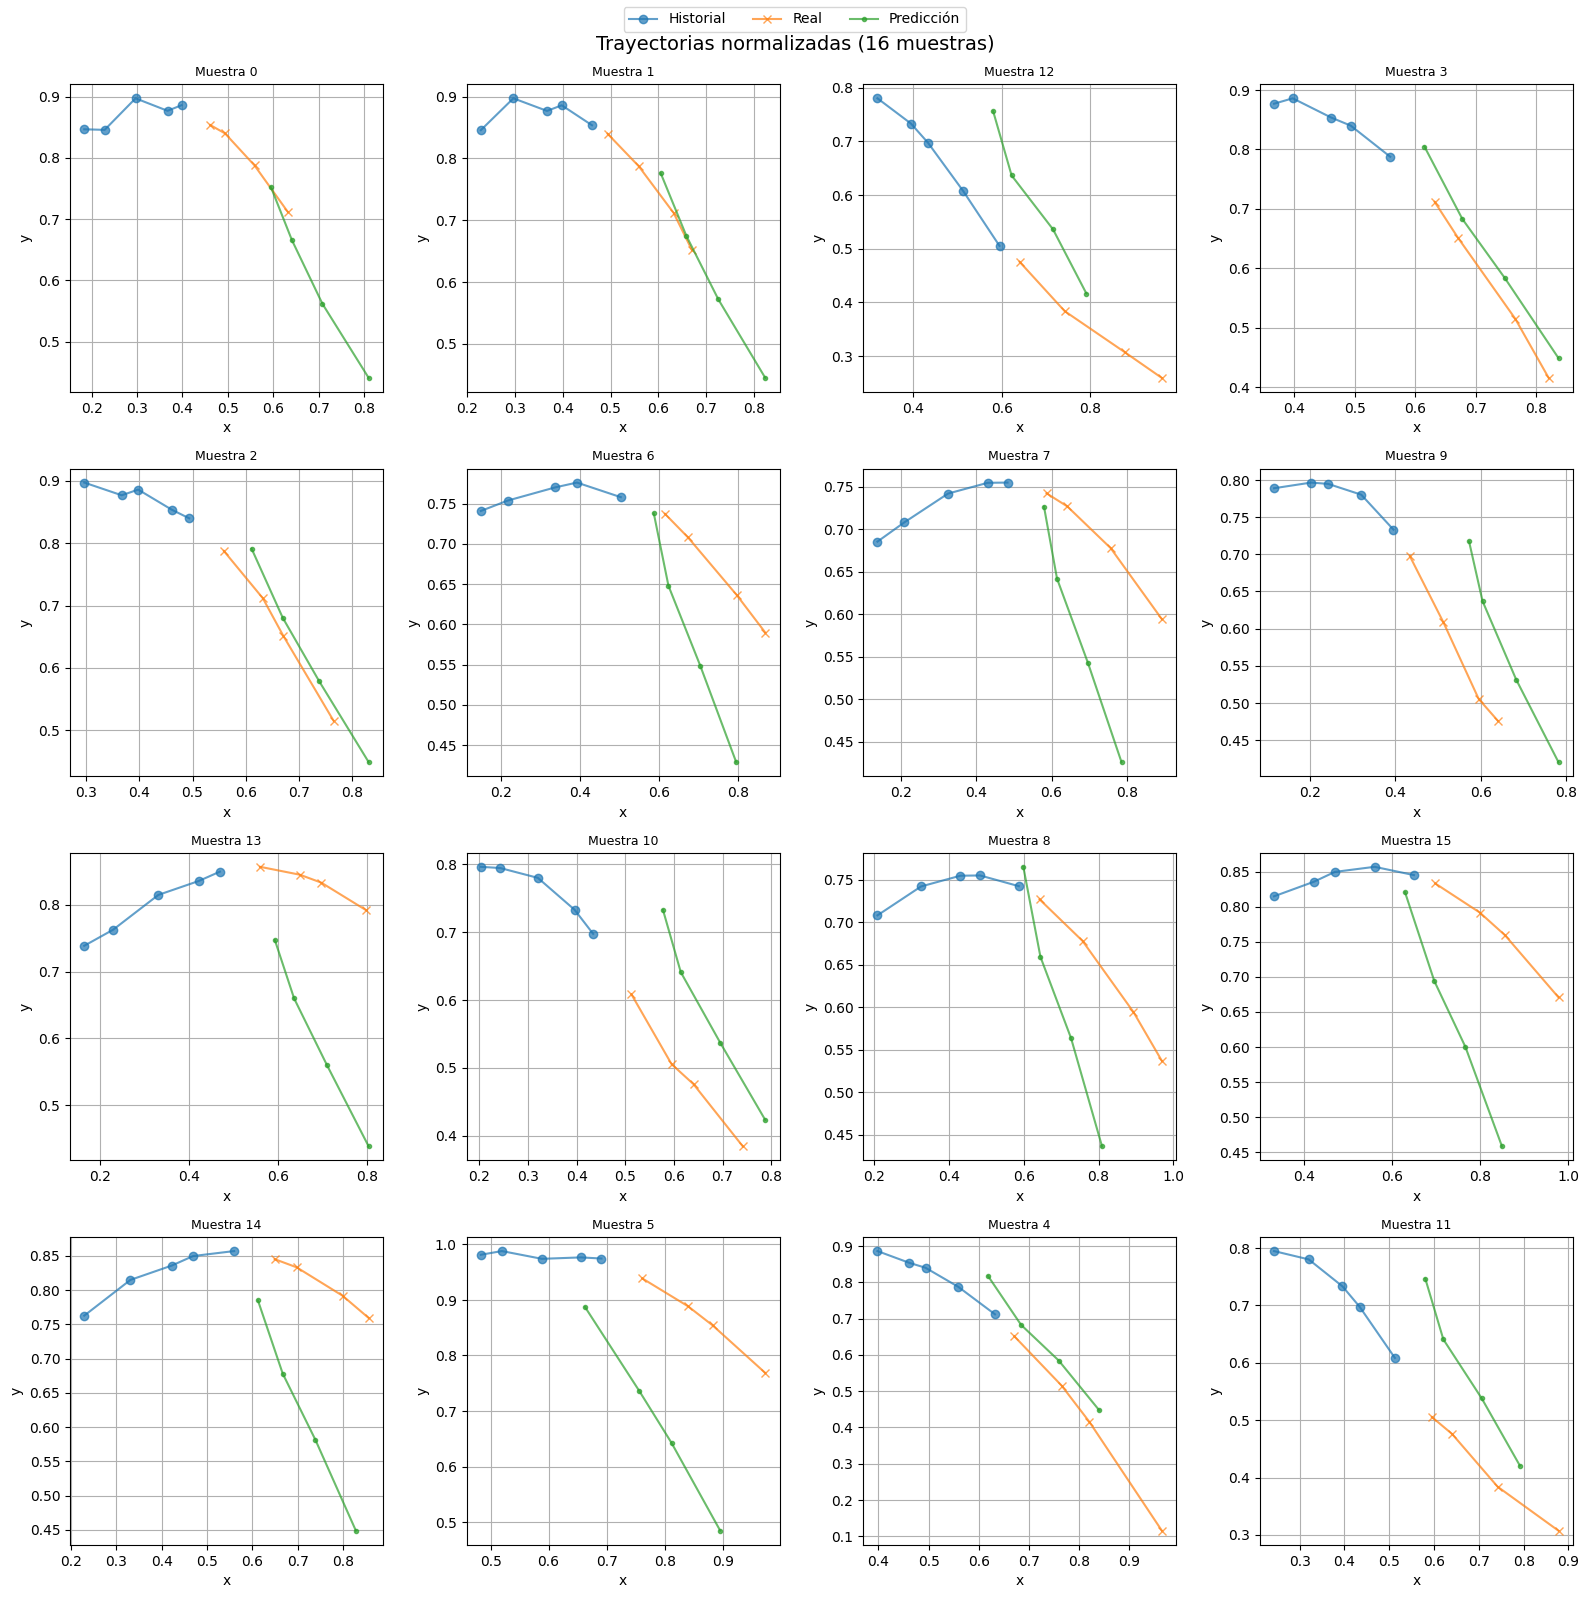

In [217]:
import matplotlib.pyplot as plt
import torch
import random

@torch.no_grad()
def visualize_random_grid(model, dataset, k=16):
    model.eval()
    idxs = random.sample(range(len(dataset)), k=min(k, len(dataset)))

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()

    for ax, i in zip(axes, idxs):
        X, Y = dataset[i]
        Yhat = model(X.unsqueeze(0)).squeeze(0).cpu()  # [T_out, 2]
        X = X.cpu(); Y = Y.cpu()

        xs_hist, ys_hist = X[:,0].numpy(), X[:,1].numpy()
        xs_true, ys_true = Y[:,0].numpy(), Y[:,1].numpy()
        xs_hat,  ys_hat  = Yhat[:,0].numpy(), Yhat[:,1].numpy()

        ax.plot(xs_hist, ys_hist, marker="o", label="Historial", alpha=0.7)
        ax.plot(xs_true, ys_true, marker="x", label="Real", alpha=0.7)
        ax.plot(xs_hat,  ys_hat,  marker=".", label="Predicción", alpha=0.7)
        ax.set_title(f"Muestra {i}", fontsize=9)
        ax.set_xlabel("x"); ax.set_ylabel("y")
        ax.grid(True)

    # Solo un legend global (arriba)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.suptitle("Trayectorias normalizadas (16 muestras)", fontsize=14)
    plt.show()

# 👉 Ejecuta con tu modelo en CPU
best_cpu = best.to("cpu")
visualize_random_grid(best_cpu, test_ds, k=16)